# PCA for combination of 3 periods

In [13]:
import numpy as np
from scipy.spatial import procrustes  # 正确导入位置
from gensim.models import Word2Vec

c1t_w2v = Word2Vec.load("D:\\CODE\\data set for QTA\\c1t_word2vec.model")
c2t_w2v = Word2Vec.load("D:\\CODE\\data set for QTA\\c2t_word2vec.model")
c3t_w2v = Word2Vec.load("D:\\CODE\\data set for QTA\\c3t_word2vec.model")

In [ ]:
# trageted word groups
words = ["人民", "革命", "改革", "党", "共产党", "阶级", "社会主义",
         "总书记", "毛泽东", "邓小平", "江泽民", "主席", "中共中央",
         "黄河", "长江", "淮河", "庐山", 
         "经济", "发展", "开放", "贸易", "商业", "公司",
         "英国", "美国", "日本", "纸老虎", "国民党", "民主", "市场"
         ]

# get word vectors from three models
vectors = []
valid_words = []  
for word in words:
    if word in c1t_w2v.wv and word in c2t_w2v.wv and word in c3t_w2v.wv:
        # combination of three models
        combined_vector = np.concatenate([
            c1t_w2v.wv[word],
            c2t_w2v.wv[word],
            c3t_w2v.wv[word]
        ])
        vectors.append(combined_vector)
        valid_words.append(word)

# transform to numpy array
vectors = np.array(vectors)


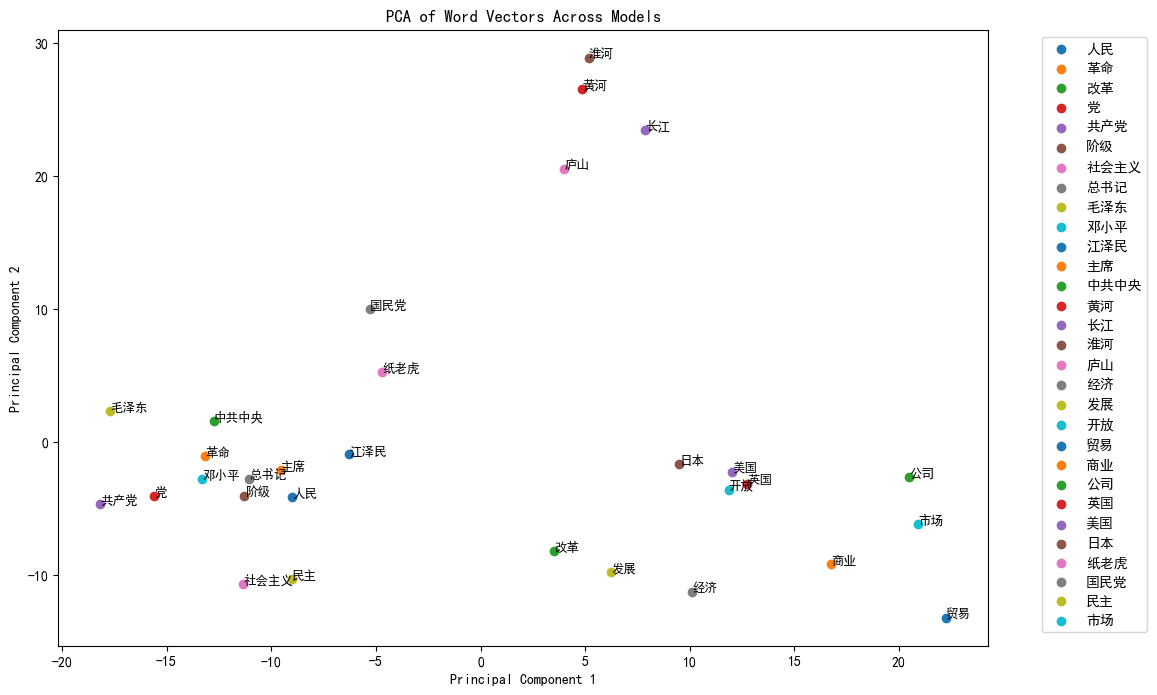

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib import rcParams

# set word format to SimHei to support Chinese characters
rcParams['font.sans-serif'] = ['SimHei']  
rcParams['axes.unicode_minus'] = False   

# PCA
pca = PCA(n_components=2)  # to 2D
reduced_vectors = pca.fit_transform(vectors)

# visualize
plt.figure(figsize=(12, 8))
for i, word in enumerate(valid_words):
    plt.scatter(reduced_vectors[i, 0], reduced_vectors[i, 1], label=word)
    plt.text(reduced_vectors[i, 0] + 0.01, reduced_vectors[i, 1] + 0.01, word, fontsize=9)

plt.title("PCA of Word Vectors Across Models")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# save the figure
plt.savefig("pca_word_vectors 2.png", dpi=300, bbox_inches='tight')  

plt.show()

# T-SNE

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from gensim.models import Word2Vec

# ====== 模型加载 ======
models = {
    "1946-1976": Word2Vec.load("D:\\CODE\\data set for QTA\\c1t_word2vec.model"),
    "1977-1989": Word2Vec.load("D:\\CODE\\data set for QTA\\c2t_word2vec.model"),
    "1990-2003": Word2Vec.load("D:\\CODE\\data set for QTA\\c3t_word2vec.model")
}

set targeted word and visualization of neighbor number K=5 and T-SNE parameter perplexity = 20

In [ ]:

target_words = ["经济", "发展", "政策", "改革", "日本", "毛", "国民党", "人民", "敌人", "开放"]
k = 5  # 近邻数量
perplexity = 20  # t-SNE参数

Find common words

In [8]:

# ====== 跨时期邻居发现 ======
def get_temporal_neighbors(target_word):
    """获取目标词在三个时段的共同邻居池"""
    neighbor_sets = []
    for era in models.keys():
        if target_word in models[era].wv:
            neighbors = models[era].wv.most_similar(target_word, topn=k)
            neighbor_sets.append({n[0] for n in neighbors})
    return list(set().union(*neighbor_sets)) + [target_word]


In [9]:

# ====== 构建现代词汇池 ======
modern_era = "1990-2003"
modern_vocab = set()  # 修复未定义错误
for word in target_words:
    modern_vocab.update(get_temporal_neighbors(word))
    

In [ ]:

# ====== 现代语义基底构建 ======
modern_vectors = []
valid_words = []
for word in modern_vocab:
    try:
        # 转换为numpy array格式（修复shape错误）
        vec = models[modern_era].wv.get_vector(word).astype(np.float64)
        modern_vectors.append(vec)
        valid_words.append(word)
    except KeyError:
        continue

# 将列表转换为numpy array（关键修复步骤）
modern_vectors = np.array(modern_vectors)  # 添加这行转换


### calculated T-SNE， and visualise


In [ ]:

# t-SNE降维
tsne = TSNE(n_components=2, perplexity=perplexity, random_state=50)
modern_embeddings = tsne.fit_transform(modern_vectors)
coord_dict = {word: coord for word, coord in zip(valid_words, modern_embeddings)}


In [12]:

# ====== 历史语义坐标优化 ======
def optimize_historical_coord(target_word, historical_era):
    """基于现代语义空间的局部调整"""
    if target_word not in models[historical_era].wv:
        return np.array([0,0])  # 处理缺失词
    
    # 获取历史时期邻居坐标
    historical_neighbors = models[historical_era].wv.most_similar(target_word, topn=k)
    neighbor_coords = []
    for n_word, _ in historical_neighbors:
        if n_word in coord_dict:
            neighbor_coords.append(coord_dict[n_word])
    
    # 初始化位置为邻居质心或随机
    if len(neighbor_coords) > 0:
        initial_pos = np.mean(neighbor_coords, axis=0)
    else:
        initial_pos = np.random.normal(0, 1, 2)
    
    return initial_pos


In [13]:

# ====== 生成时空坐标数据 ======
historical_positions = {}
for word in target_words:
    historical_positions[word] = {
        "1946-1976": optimize_historical_coord(word, "1946-1976"),
        "1977-1989": optimize_historical_coord(word, "1977-1989"),
        "1990-2003": coord_dict.get(word, [0,0])
    }


In [14]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# ====== 全局字体配置 ======
mpl.rcParams['font.sans-serif'] = ['SimHei']  
mpl.rcParams['axes.unicode_minus'] = False    

In [15]:

# 坐标优化逻辑（导致线性变化）
def optimize_historical_coord(word, era):
    neighbors = model[era].wv.most_similar(word, topn=5)  # 取5近邻
    return np.mean([coord_dict[n] for n,_ in neighbors])  # 质心计算

plot detail settings

In [16]:
def plot_semantic_evolution(word):
    plt.figure(figsize=(10, 6))  # 强制白背景
    
    era_config = {
        "1946-1976": {"x": 0.2, "y": 1946, "color": "#CD5C5C", "label": "1946-1976"},
        "1977-1989": {"x": 0.5, "y": 1968, "color": "#D2691E", "label": "1977-1989"},
        "1990-2003": {"x": 0.8, "y": 1990, "color": "#FF6347", "label": "1990-2003"}
    }

    class SmartTextLayout:
        def __init__(self):
            self.occupied = set()
            self.min_distance = 0.15  # 最小间距控制
            
        def get_position(self, base_x, base_y):
            for r in np.linspace(0.2, 0.35, 6):  # 动态半径调整
                for theta in np.linspace(0, 2*np.pi, 24, False):
                    x = base_x + r * np.cos(theta)
                    y = base_y + r * np.sin(theta)
                    
                    # 三重保护机制
                    if (x > 0.25 and  # Y轴保护
                        self.check_collision(x, y) and 
                        np.sqrt((x-base_x)**2 + (y-base_y)**2) > 0.12):  # 中心保护
                        self.occupied.add((round(x,2), round(y,2)))  # 精度控制
                        return (x, y)
            return (base_x + 0.3, base_y + 0.1)  # 保底位置
            
        def check_collision(self, x, y):
            return all(np.sqrt((x-ex)**2 + (y-ey)**2) > self.min_distance 
                     for (ex, ey) in self.occupied)

    # 绘制时间节点（点在下层）
    for era in era_config.values():
        plt.scatter(era["x"], era["y"], 
                   c=era["color"], 
                   s=150, 
                   edgecolor='white',
                   linewidth=1.5,
                   zorder=2)  # 点在下层

    # 文字布局引擎
    layout = SmartTextLayout()
    
    for era_name in era_config:
        conf = era_config[era_name]
        model = models[era_name]
        
        if word in model.wv:
            # 获取相似词（带语义过滤）
            similar_words = [
                w[0] for w in model.wv.most_similar(word, topn=5) 
                if model.wv.similarity(word, w[0]) > 0.3
            ][:5]  # 严格取前5个
            
            for term in similar_words:
                x, y = layout.get_position(conf["x"], conf["y"])
                plt.text(x, y, term,
                        color='#404040',
                        fontsize=10,
                        ha='center',
                        va='center',
                        zorder=3)  # 文字在上层

    # 精确箭头参数（匹配截图）
    arrow_style = dict(
        arrowstyle="-|>",
        color="#0066CC",  # 标准商务蓝
        linewidth=2.8,
        alpha=0.95,
        linestyle="-",
        mutation_scale=18,
        zorder=1  # 箭头在最底层
    )
    
    plt.annotate("", xy=(0.5,1968), xytext=(0.2,1946), arrowprops=arrow_style)
    plt.annotate("", xy=(0.8,1990), xytext=(0.5,1968), arrowprops=arrow_style)
    
    # 添加浅浅的网格线
    plt.grid(
      color='#D8D8D8',  # 浅灰色网格线
      linestyle='--',   # 虚线样式
      linewidth=0.5,    # 线宽
      alpha=0.7         # 透明度
    )
    
    plt.gca().xaxis.set_visible(True)  # 确保 X 轴可见
    plt.gca().yaxis.set_visible(True)  # 确保 Y 轴可见
    plt.grid(
      color='#D8D8D8',  # 浅灰色网格线
      linestyle='--',   # 虚线样式
      linewidth=0.5,    # 线宽
      alpha=0.7         # 透明度
    )
    
    # 坐标轴设置（严格匹配截图）
    plt.gca().xaxis.set_visible(False)
    plt.yticks(
        ticks=[1946, 1968, 1990],
        labels=[conf["label"] for conf in era_config.values()],
        fontsize=12,
        color='#333333'
    )
    plt.ylim(1940, 2000)
    
    # 去除所有边框
    for spine in plt.gca().spines.values():
        spine.set_visible(False)
        
    plt.title(f"Semantic Evolution of '{word}'", 
             fontsize=15, 
             pad=20,
             fontweight='bold',
             color='#2B2B2B')
    
    plt.tight_layout()
    
    # 保存图像
    plt.savefig(f"{word}_semantic_evolution.png", dpi=300, bbox_inches='tight', facecolor='white')
    
    plt.show()

10 charts generation (I only used 5)

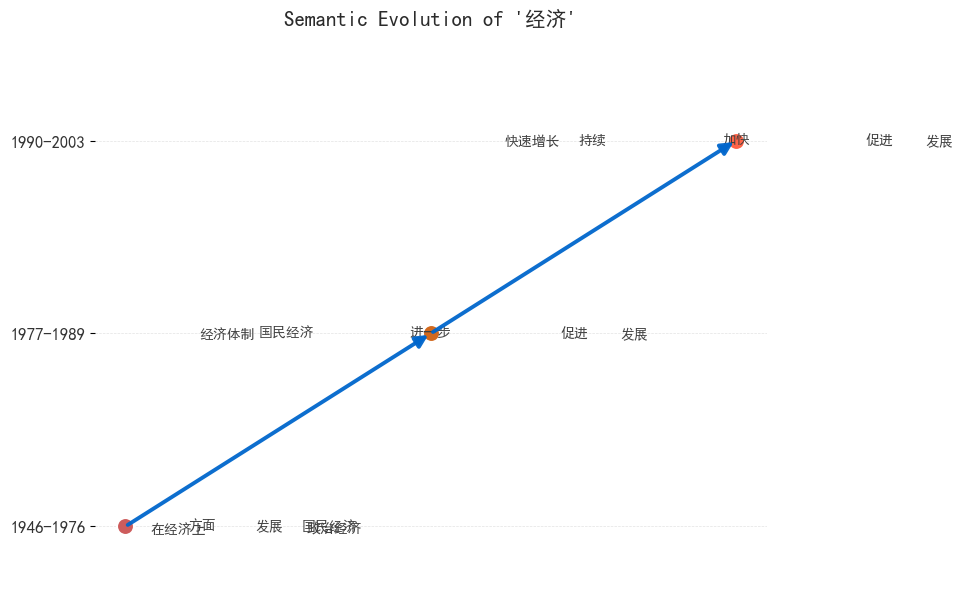

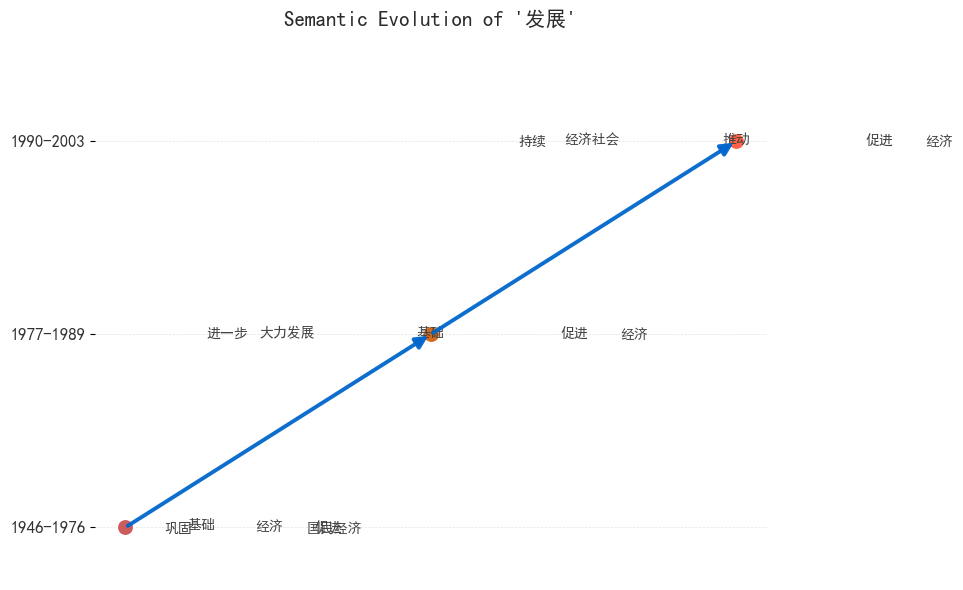

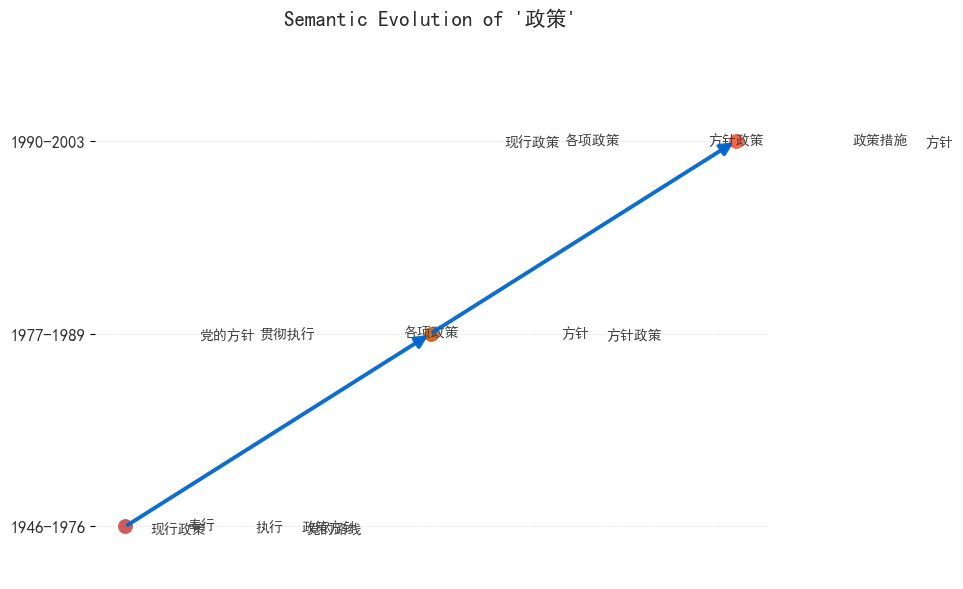

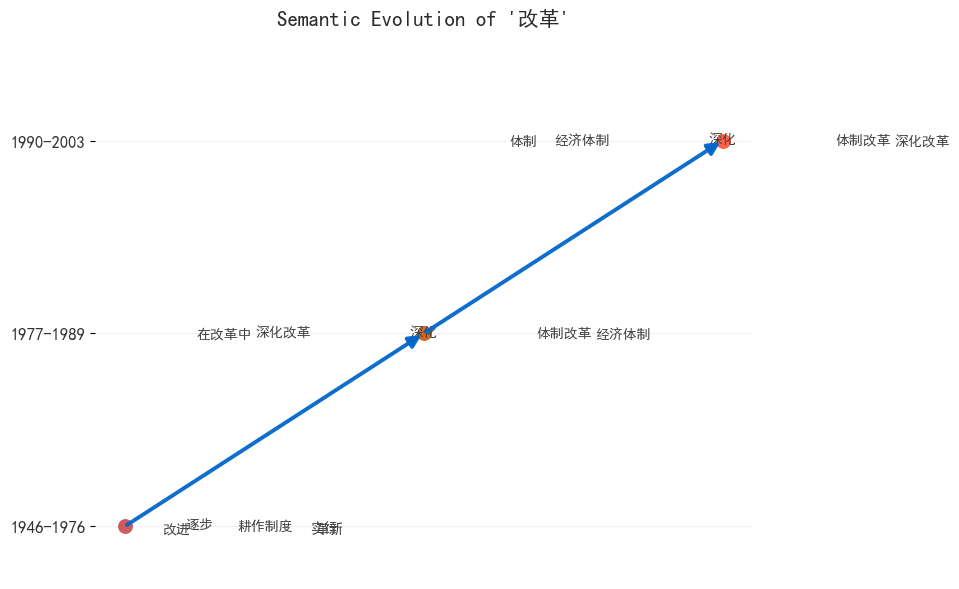

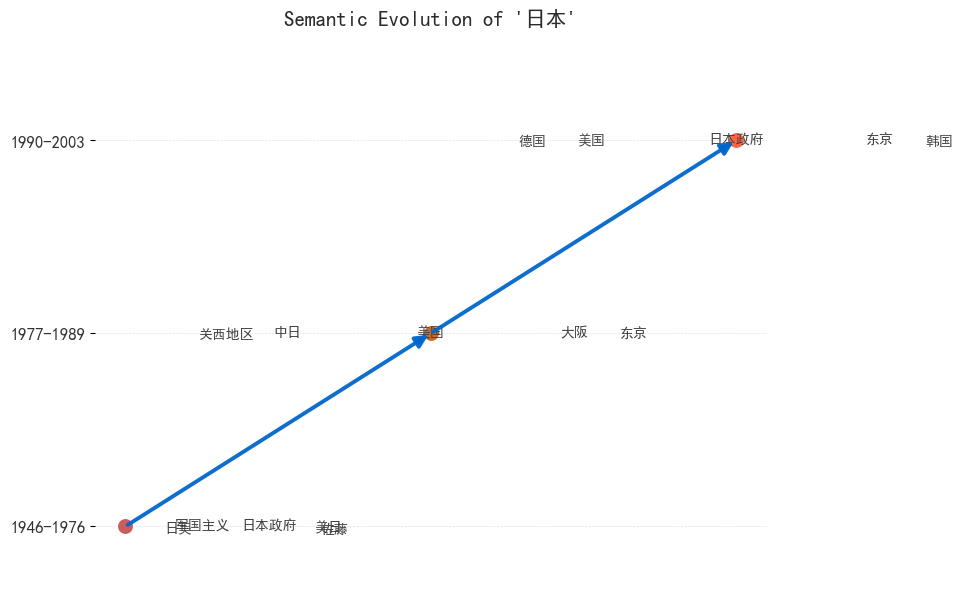

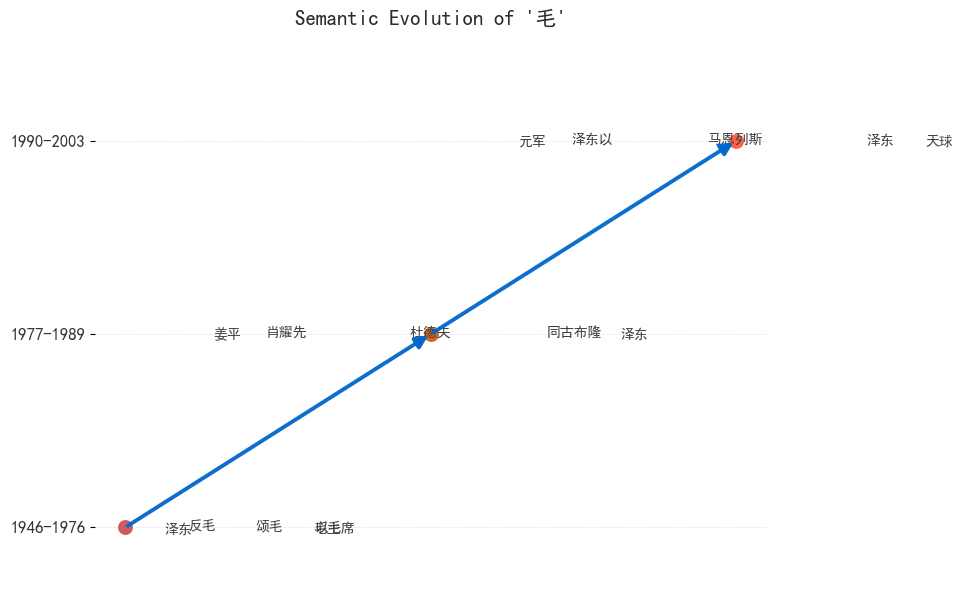

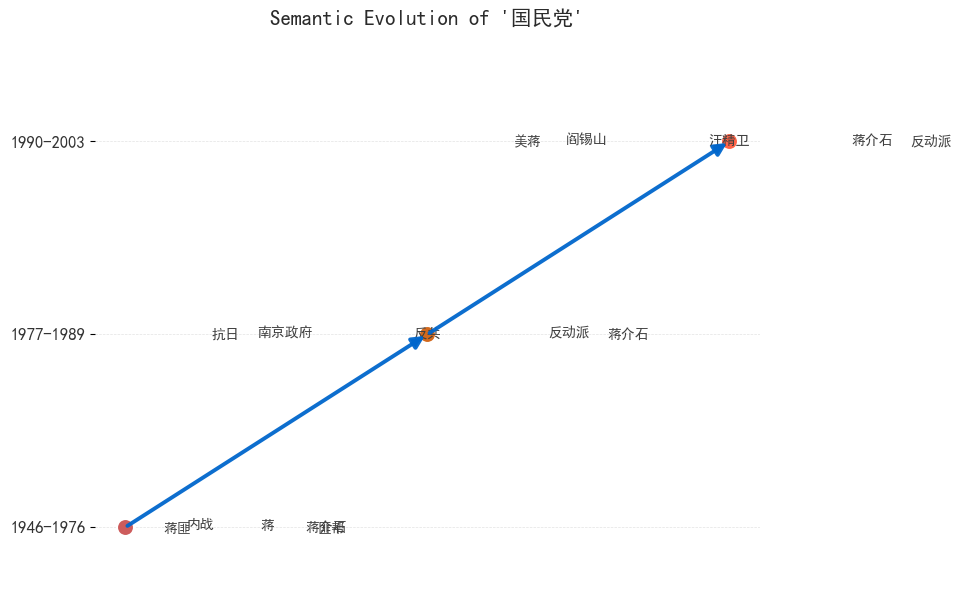

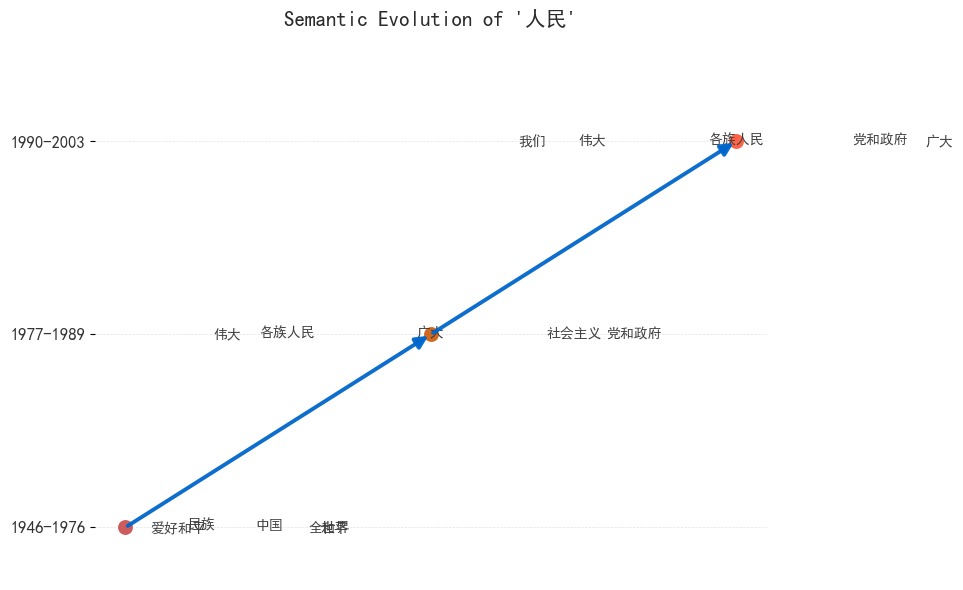

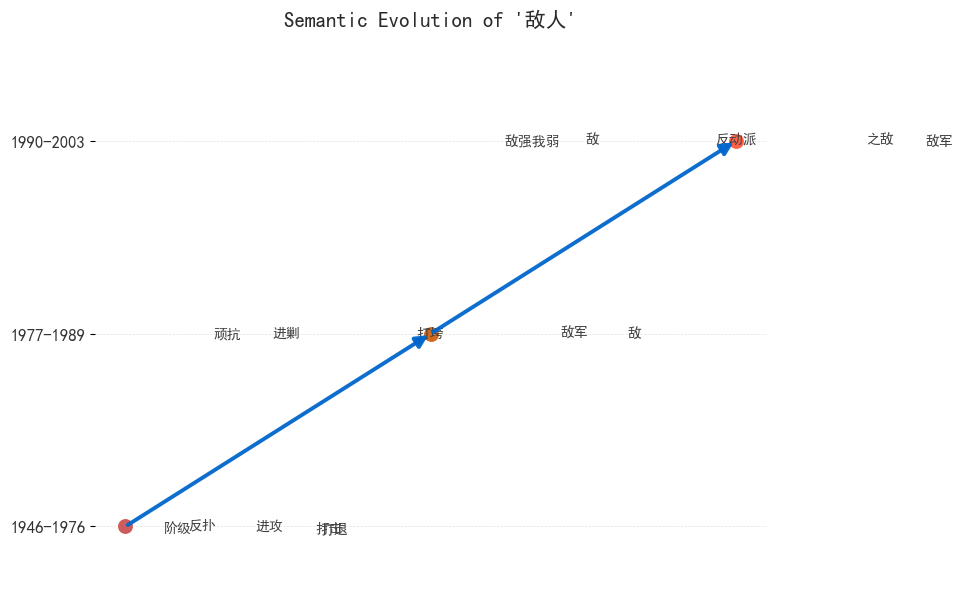

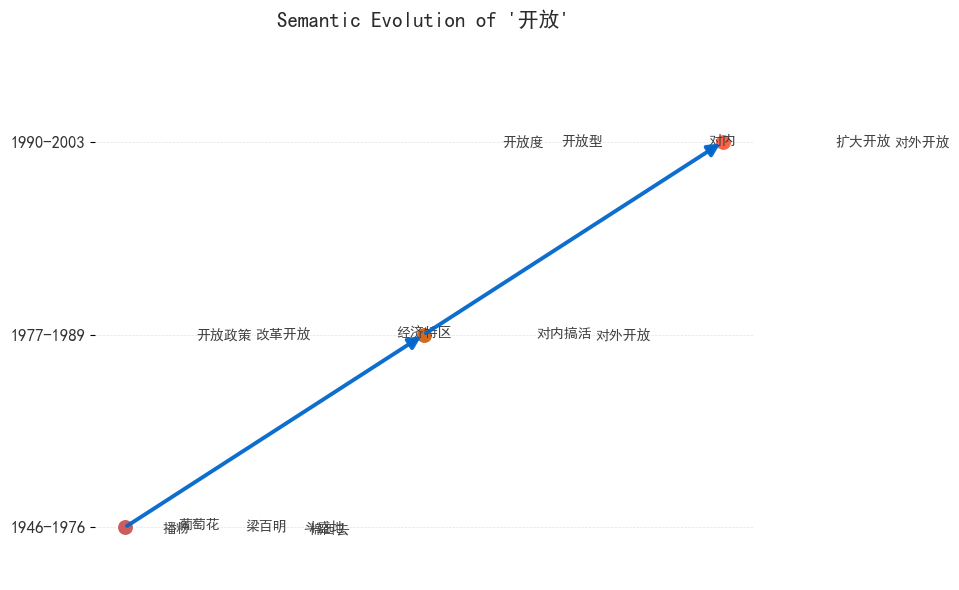

In [18]:

# ====== 批量生成图表 ======
for word in target_words:
    plot_semantic_evolution(word)

## 3. whole map of shift for certain words

In [1]:
import numpy as np
from scipy.linalg import orthogonal_procrustes
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [2]:


# 配置全局中文字体（Windows系统示例）
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 微软雅黑
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 加载模型
models = {
    "1946-1976": Word2Vec.load("D:\\CODE\\data set for QTA\\c1t_word2vec.model"),
    "1977-1989": Word2Vec.load("D:\\CODE\\data set for QTA\\c2t_word2vec.model"),
    "1990-2003": Word2Vec.load("D:\\CODE\\data set for QTA\\c3t_word2vec.model")
}

# 目标词汇与有效性验证
target_words = ["经济", "发展", "政策", "改革", "日本", "毛", "国民党", "人民", "敌人", "长江", "开放"]
valid_words = [word for word in target_words 
              if all(word in model.wv for model in models.values())]
print(f"有效分析词汇：{valid_words}")

# 模型对齐（使用目标词作为锚点）
def procrustes_align(models, anchor_words):
    base_model = models["1946-1976"]
    aligned_models = {"1946-1976": base_model}
    
    for period in ["1977-1989", "1990-2003"]:
        # 构建锚点词矩阵
        X = np.array([base_model.wv[word] for word in anchor_words])
        Y = np.array([models[period].wv[word] for word in anchor_words])
        
        # 计算正交旋转矩阵
        R, _ = orthogonal_procrustes(Y, X)
        
        # 对齐所有词汇
        aligned_vecs = models[period].wv.vectors @ R
        
        # 创建对齐后的模型
        aligned_model = Word2Vec(vector_size=base_model.vector_size)
        aligned_model.wv.add_vectors(
            models[period].wv.index_to_key,
            aligned_vecs
        )
        aligned_models[period] = aligned_model
    
    return aligned_models

aligned_models = procrustes_align(models, valid_words)

# 构建跨时期数据矩阵
period_vectors = {}
for period in aligned_models:
    period_vectors[period] = np.array([aligned_models[period].wv[word] for word in valid_words])

# 以第一个时期训练PCA
pca = PCA(n_components=2)
base_pca = pca.fit_transform(period_vectors["1946-1976"])

# 转换其他时期数据（保持相同PCA空间）
projected_vectors = {
    "1946-1976": base_pca,
    "1977-1989": pca.transform(period_vectors["1977-1989"]),
    "1990-2003": pca.transform(period_vectors["1990-2003"])
}


有效分析词汇：['经济', '发展', '政策', '改革', '日本', '毛', '国民党', '人民', '敌人', '长江', '开放']


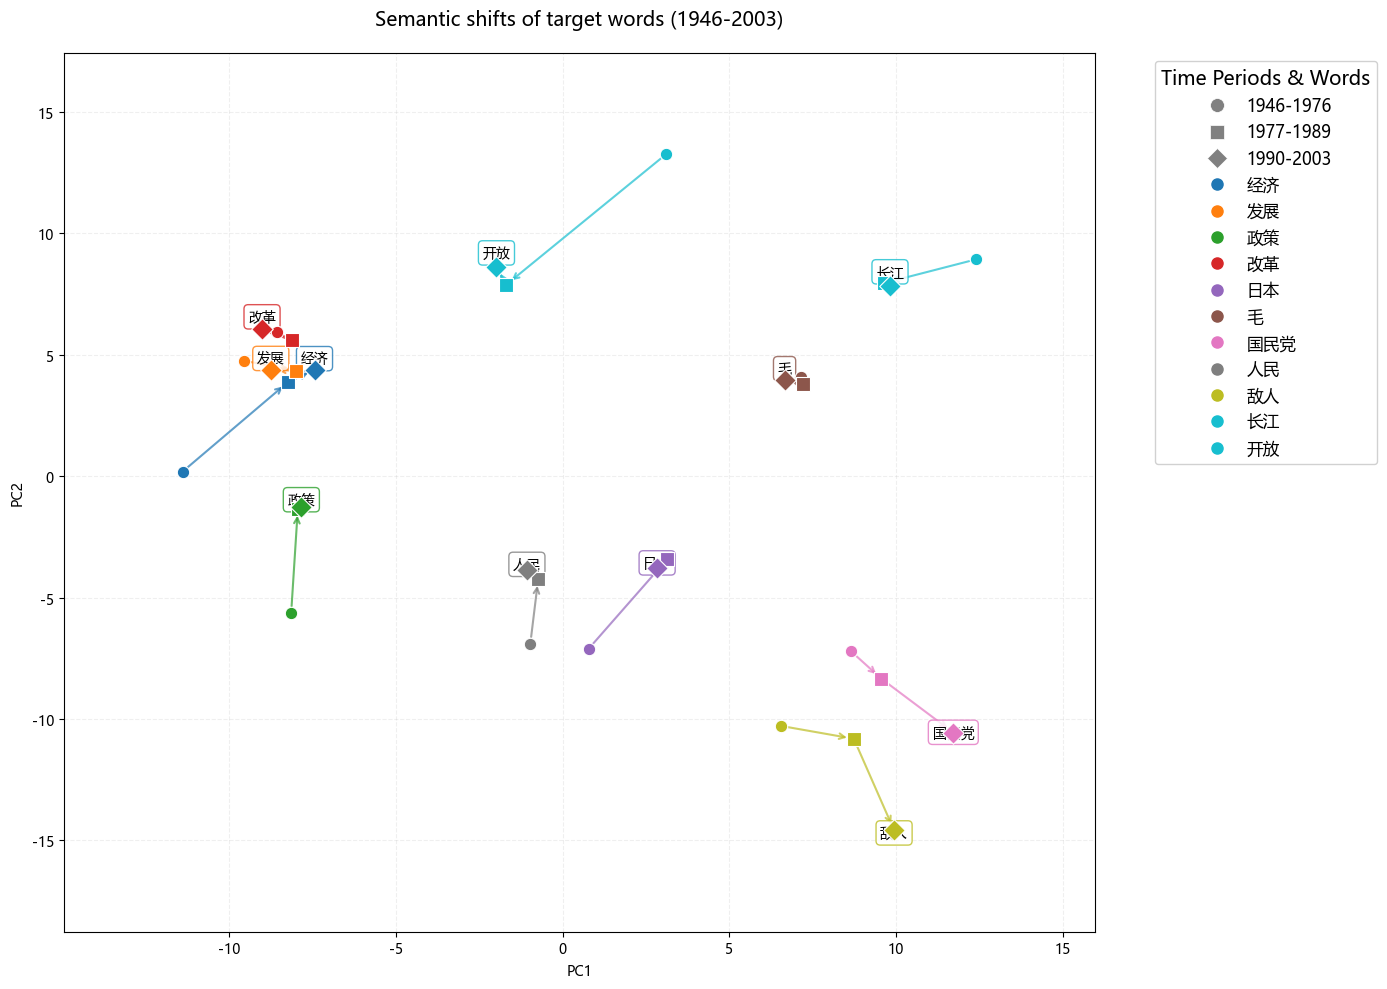

In [5]:
# 可视化参数配置
colors = plt.cm.tab10(np.linspace(0, 1, len(valid_words)))
marker_dict = {
    "1946-1976": {"marker": "o", "s": 80},
    "1977-1989": {"marker": "s", "s": 100},
    "1990-2003": {"marker": "D", "s": 120}
}

# 创建可视化画布
fig, ax = plt.subplots(figsize=(14, 10))

# 绘制每个词汇的时空轨迹
for word_idx, word in enumerate(valid_words):
    # 获取各时期坐标
    points = np.array([
        projected_vectors["1946-1976"][word_idx],
        projected_vectors["1977-1989"][word_idx],
        projected_vectors["1990-2003"][word_idx]
    ])
    
    # 绘制动态箭头
    for i in range(2):
        ax.annotate("",
                   xy=points[i+1], 
                   xytext=points[i],
                   arrowprops=dict(
                       arrowstyle="->",
                       color=colors[word_idx],
                       lw=1.5,
                       alpha=0.7,
                       shrinkA=5,
                       shrinkB=5
                   ))
    
    # 绘制各时期标记
    for period_idx, (period, style) in enumerate(marker_dict.items()):
        ax.scatter(*points[period_idx],
                  color=colors[word_idx],
                  **style,
                  edgecolor='w',
                  linewidth=0.8,
                  zorder=10)

# 添加最终位置标注
for word_idx, word in enumerate(valid_words):
    x, y = projected_vectors["1990-2003"][word_idx]
    ax.text(x, y+(y*0.03), word,  # 动态偏移防止重叠
           fontsize=10,
           ha='center',
           va='bottom',
           bbox=dict(boxstyle="round", 
                    facecolor="white", 
                    alpha=0.8,
                    edgecolor=colors[word_idx]))

# 添加图例
# 时间段图例
legend_elements = [
    plt.Line2D([0], [0],
              marker=style["marker"],
              color='w',
              label=period,
              markersize=10,
              markerfacecolor='gray',
              markeredgewidth=0.5)
    for period, style in marker_dict.items()
]

# 颜色和词汇对应的图例
word_color_legend = [
    plt.Line2D([0], [0],
               marker='o',
               color=colors[word_idx],
               label=word,
               markersize=8,
               linestyle='None')
    for word_idx, word in enumerate(valid_words)
]

# 合并图例并移到图表外
ax.legend(handles=legend_elements + word_color_legend,  # 合并时间段和颜色图例
          title="Time Periods & Words",
          loc='upper left',  # 图例放置在图表右上方
          bbox_to_anchor=(1.05, 1),  # 图例位置（右上角对齐图表顶部）
          frameon=True,
          framealpha=0.9,
          fontsize=12,  # 放大标签字体
          title_fontsize=14)  # 放大标题字体

# 设置坐标轴
ax.set_xlabel(f"PC1")
ax.set_ylabel(f"PC2")
ax.set_title("Semantic shifts of target words (1946-2003)", fontsize=14, pad=20)

# 优化显示范围
all_points = np.concatenate(list(projected_vectors.values()))
x_padding = (all_points[:,0].max() - all_points[:,0].min()) * 0.15
y_padding = (all_points[:,1].max() - all_points[:,1].min()) * 0.15
ax.set_xlim(all_points[:,0].min()-x_padding, all_points[:,0].max()+x_padding)
ax.set_ylim(all_points[:,1].min()-y_padding, all_points[:,1].max()+y_padding)

# 添加辅助网格
ax.grid(alpha=0.2, linestyle='--', which='both')

plt.tight_layout()
plt.show()